In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import shapely
import matplotlib.pyplot as plot
%matplotlib inline


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Reading Inputs

Here, we consider Bangalore travel time data for January 2020 to March 2020.

In [2]:
travel_times = pd.read_csv('/kaggle/input/uber-movement-data/Travel_Times.csv')
travel_times_daily = pd.read_csv('/kaggle/input/uber-movement-data/Travel_Times_Daily.csv')
travel_times_day = pd.read_csv('/kaggle/input/uber-movement-data/Travel_Times_time_of_day.csv')
travel_times_week = pd.read_csv('/kaggle/input/uber-movement-data/Travel_Times_day_of_week.csv')
bnglr_wards_hourly = pd.read_csv('/kaggle/input/uber-movement-data/bangalore-wards-2020-1-All-HourlyAggregate.csv')
bnglr_wards_weekly = pd.read_csv('/kaggle/input/uber-movement-data/bangalore-wards-2020-1-WeeklyAggregate.csv')
bnglr_wards_monthly = pd.read_csv('/kaggle/input/uber-movement-data/bangalore-wards-2020-1-All-MonthlyAggregate.csv')

We'll consider the hourly travel time average for modelling.

In [3]:
bnglr_wards_hourly.head(2)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,183,54,22,3071.62,553.06,3016.74,1.22
1,186,24,22,991.61,241.55,969.45,1.22


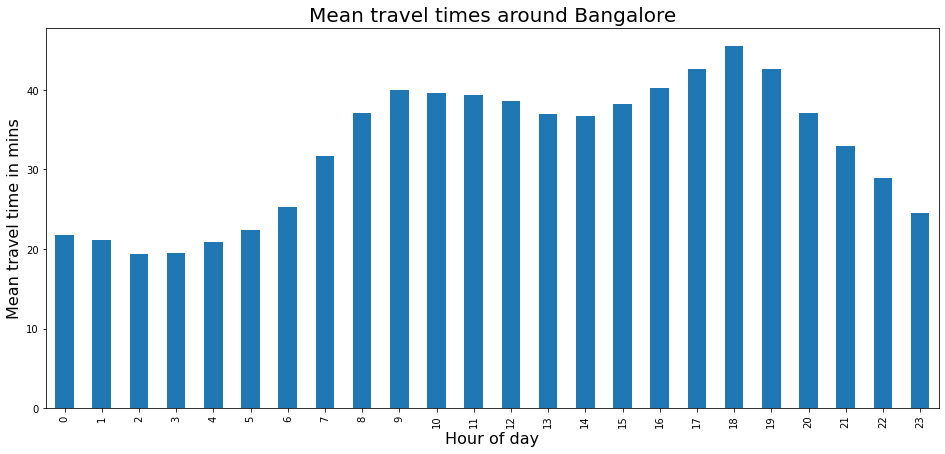

In [4]:
mean_travel_time_by_hour_of_day = bnglr_wards_hourly.groupby('hod')['mean_travel_time'].mean()/60
plt = mean_travel_time_by_hour_of_day.plot(kind="bar", figsize=(16,7))
plt.set_title('Mean travel times around Bangalore',fontsize=20)
plt.set_xlabel('Hour of day', fontsize=16)
_ = plt.set_ylabel('Mean travel time in mins', fontsize=16)

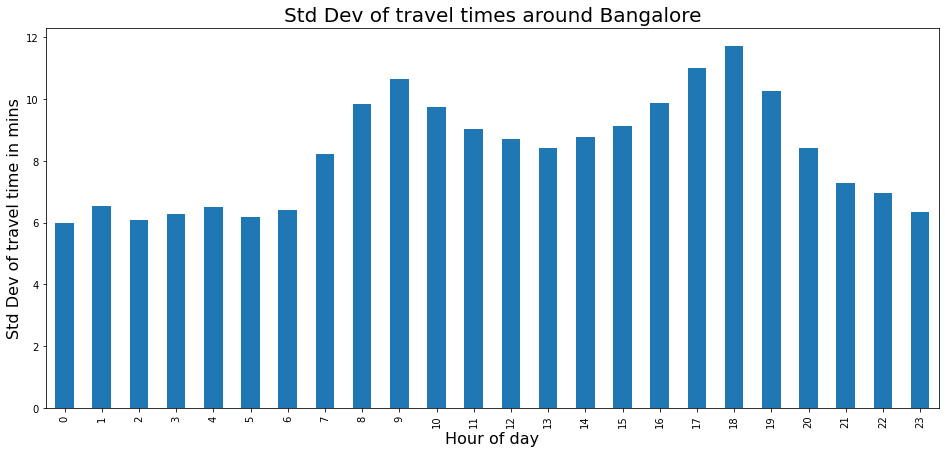

In [5]:
std_dev_time_by_hour_of_day = bnglr_wards_hourly.groupby('hod')['standard_deviation_travel_time'].mean()/60
plt = std_dev_time_by_hour_of_day.plot(kind="bar", figsize=(16,7))
plt.set_title('Std Dev of travel times around Bangalore',fontsize=20)
plt.set_xlabel('Hour of day', fontsize=16)
_ = plt.set_ylabel('Std Dev of travel time in mins', fontsize=16)

# The ward data

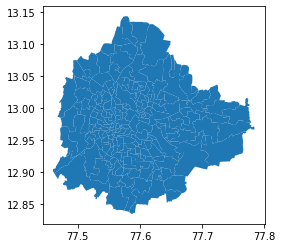

In [6]:
bglr=gpd.read_file('/kaggle/input/uber-movement-data/bangalore_wards.json')
bglr.plot()

In [7]:
bglr.head()

,WARD_NO,WARD_NAME,MOVEMENT_ID,DISPLAY_NAME,geometry
0,2,Chowdeswari Ward,1,"Unnamed Road, Bengaluru","MULTIPOLYGON (((77.59229 13.09720, 77.59094 13..."
1,3,Atturu,2,"9th Cross Bhel Layout, Adityanagar, Vidyaranya...","MULTIPOLYGON (((77.56862 13.12705, 77.57064 13..."
2,4,Yelahanka Satellite Town,3,"15th A Cross Road, Yelahanka Satellite Town, Y...","MULTIPOLYGON (((77.59094 13.09842, 77.59229 13..."
3,51,Vijnanapura,4,"SP Naidu Layout 4th Cross Street, SP Naidu Lay...","MULTIPOLYGON (((77.67683 13.01147, 77.67695 13..."
4,53,Basavanapura,5,"Medahalli Kadugodi Road, Bharathi Nagar, Krish...","MULTIPOLYGON (((77.72899 13.02061, 77.72994 13..."


# Picking centroids to represent an area

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


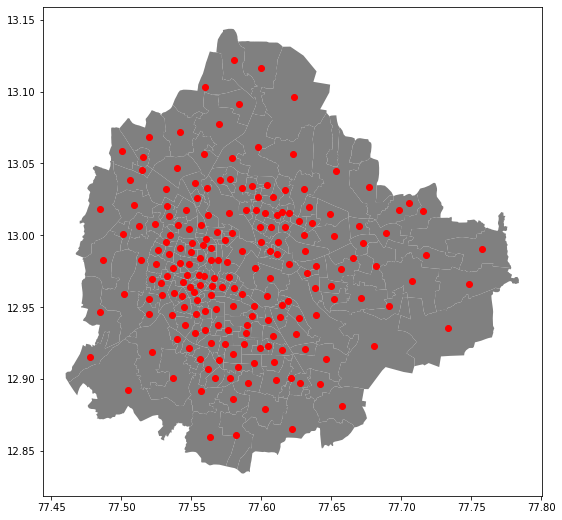

In [8]:
bglr = bglr.drop(columns=['WARD_NO', 'MOVEMENT_ID'])
bglr_c = bglr.copy()
bglr_c.geometry = bglr_c['geometry'].centroid
fig, ax = plot.subplots(figsize=(9,9))
bglr.plot(color='grey',ax=ax)
bglr_c.plot(color='red',ax=ax)

In [9]:
id_to_dest = travel_times[['Destination Movement ID', 'Destination Display Name']]
id_to_dest.columns = ['id', 'name']
id_to_dest.head()


,id,name
0,1,"Unnamed Road, Bengaluru"
1,2,"9th Cross Bhel Layout, Adityanagar, Vidyaranya..."
2,3,"15th A Cross Road, Yelahanka Satellite Town, Y..."
3,4,"SP Naidu Layout 4th Cross Street, SP Naidu Lay..."
4,5,"Medahalli Kadugodi Road, Bharathi Nagar, Krish..."


# Get some random points from each ward to diversify representation

In [10]:
from shapely.geometry import Point
import random

# The number of rows with random points to be created corresponding to each row in source df
number = 3

def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points

def diversify_geo_data(df):
    new_df = gpd.GeoDataFrame()
    common_columns = df.columns
    common_columns.tolist().remove('geometry')
    for row in df.itertuples():
        points = random_points_in_polygon(number, row.geometry)
        for point in points:
            tmp = gpd.GeoDataFrame(columns=df.columns, data=[list(row[1:3]) + [point]])
            new_df = new_df.append(tmp, ignore_index=True)
    return new_df
            

diversified_points = diversify_geo_data(bglr)
diversified_points.sample(5)

,WARD_NAME,DISPLAY_NAME,geometry
125,Mahalakshimpuram,"0 8th Cross Road, Satyanarayana Layout, Maruth...",POINT (77.54116 13.01009)
303,Okalipuram,"0 3rd Cross Road, 4N Block, Ramchandrapuram, S...",POINT (77.56569 12.98792)
218,Lingarajapura,"0 Lokesh Tent Main Road, Lingarajapura Village...",POINT (77.62889 13.00852)
214,Kadugondanahalli,"0 5th Cross Road, Vinobha Nagar, Kadugondanaha...",POINT (77.61905 13.01672)
45,Kodigehalli,"Gulmohar Residency, 6th A Cross Road, Bhadrapp...",POINT (77.57405 13.05721)


In [11]:
diversified_points.shape

(594, 3)

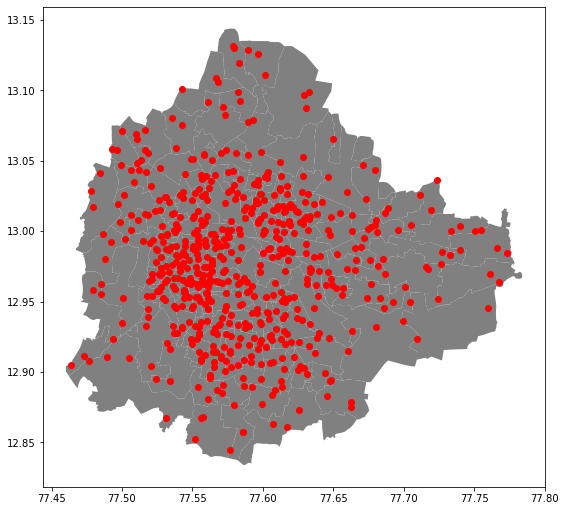

In [12]:
fig, ax = plot.subplots(figsize=(9,9))
bglr.plot(color='grey',ax=ax)
diversified_points.plot(color='red',ax=ax)

# Cleaning up data for analysis

Got source and destination data and removed unneeded columns like geometric_mean_travel_time and geometric_standard_deviation_travel_time.

In [13]:
time_df = pd.merge(bnglr_wards_hourly, id_to_dest, left_on=['sourceid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'])
time_df = time_df.rename(columns={'name': 'Source Name'})
time_df = pd.merge(time_df, id_to_dest, left_on=['dstid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id'])
time_df = time_df.rename(columns={'name': 'Destination Name'})
time_df = time_df.sort_values(by=['sourceid', 'dstid', 'hod'])
time_df.tail(5)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name
272319,198,197,20,4001.08,583.40,"BGS Road, Kodipalya, Bengaluru","0 3rd Cross Road, Manjunatha Layout, Marathaha..."
272337,198,197,21,3636.68,614.63,"BGS Road, Kodipalya, Bengaluru","0 3rd Cross Road, Manjunatha Layout, Marathaha..."
272324,198,197,22,3082.11,471.47,"BGS Road, Kodipalya, Bengaluru","0 3rd Cross Road, Manjunatha Layout, Marathaha..."
272330,198,197,23,2905.84,619.53,"BGS Road, Kodipalya, Bengaluru","0 3rd Cross Road, Manjunatha Layout, Marathaha..."
366043,198,198,23,458.84,562.24,"BGS Road, Kodipalya, Bengaluru","BGS Road, Kodipalya, Bengaluru"


In [14]:
bglr_c.shape

(198, 3)

In [15]:
diversified_points.shape

(594, 3)

In [16]:
full_bglr = bglr_c.append(diversified_points, ignore_index=True)
full_bglr.shape

(792, 3)

In [17]:
time_df2 = pd.merge(time_df, full_bglr, left_on=['Source Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Source Ward Name', 'geometry': 'Source Geometry'})
time_df2 = pd.merge(time_df2, full_bglr, left_on=['Destination Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Destination Ward Name', 'geometry': 'Destination Geometry'})
time_df2.sample(3)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name,Source Ward Name,Source Geometry,Destination Ward Name,Destination Geometry
7161523,85,114,4,1464.73,236.73,"Kensington Road, Ulsoor, Bengaluru","0 16th Main Road, CHBS Layout, Stage 2, Vijaya...",Halsoor,POINT (77.61982 12.97970),Marenahalli,POINT (77.52851 12.97048)
761758,62,12,18,2387.54,529.95,"null4th Cross Road, Modi Garden, Kaval Bairasa...","5th Main Singapura Layout, Bengaluru",Devara Jeevanahalli,POINT (77.60056 13.01131),Kuvempu Nagar,POINT (77.54249 13.07504)
7044468,129,112,14,950.56,522.18,"0 Chowdappa Road, Cobaley Colony, Azad Nagar, ...","0 17th A Cross Road, Agrahara Dasarahalli, Raj...",Rayapuram,POINT (77.55823 12.96265),Agrahara Dasarahalli,POINT (77.54154 12.98050)


In [18]:
time_df2.shape

(13227072, 11)

In [19]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

import os.path
def file_exists(filename):
    return os.path.exists(filename)

input_path = '../input/uber-travel-time-prediction/'

# Calculating distances to use as a feature

In [20]:
import geopy.distance

def calc_distance(x):
    src_point = (x['Source Geometry'].y, x['Source Geometry'].x)
    dest_point = (x['Destination Geometry'].y, x['Destination Geometry'].x)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

filename = 'Df_for_modelling.bin'
path = input_path + filename
if file_exists(path):
    # skip to next section since the results here are already precalculated
    pass
else:
    print('Creating distance file')
    time_df2['Geodesic Distance'] = time_df2.apply(func = calc_distance, axis=1)
    df = time_df2


In [21]:
filename = 'Df_for_modelling.bin'
path = input_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        final_df = pickle.load(file)
else:
    print('Creating final df file')
    final_df = df.copy()
    final_df['Source lat'] = final_df['Source Geometry'].apply(lambda pt: float(pt.y))
    final_df['Source long'] = final_df['Source Geometry'].apply(lambda pt: float(pt.x))
    final_df['Dest lat'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.y))
    final_df['Dest long'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.x))

    
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance']
outcome = ['mean_travel_time']
final_df = final_df[features + outcome]

try:
    save_object(final_df, filename)
except:
    pass

# Modelling

Model without eval set


In [22]:

X = final_df[features]
y = final_df[outcome]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)


In [23]:

import xgboost as xgb

filename = 'XGB_model_4.bin'
path = input_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        my_model = pickle.load(file)
else:
    my_model = xgb.XGBRegressor(n_estimators=400, learning_rate=0.05, n_jobs=4)
    my_model.fit(X_train, y_train,verbose=False)
    
try:    
    save_object(X_train, 'train_set_x.bin')
    save_object(y_train, 'train_set_y.bin')
    save_object(X_test, 'test_set_x.bin')
    save_object(y_test, 'test_set_y.bin')
    save_object(my_model, filename)
except:
    pass

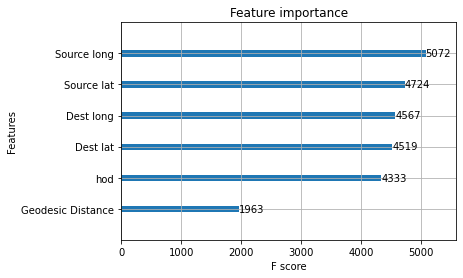

In [24]:
xgb.plot_importance(my_model)

Note: the travel time is in seconds, so as we see below, the error is pretty low.

In [25]:
predictions = my_model.predict(X_test)

from sklearn import metrics

r2 = metrics.r2_score(y_test, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, predictions)
print('MAE: {}\n'.format(mae))


R2: 0.9469694313445145

MSE: 62517.27446947882

RMSE: 250.03454655202913

MAE: 189.64726565111118



/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


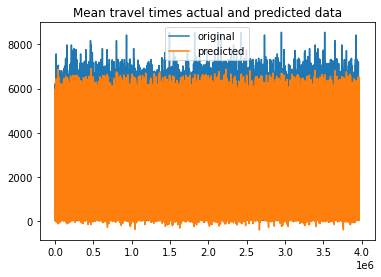

In [26]:
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="original")
plot.plot(x_ax, predictions, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

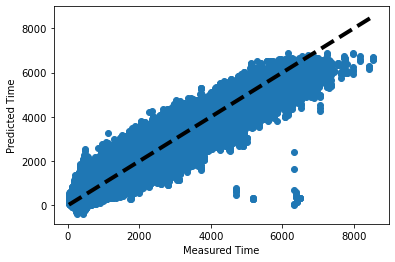

In [27]:
fig, ax = plot.subplots()
ax.scatter(y_test, predictions)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

In [28]:
from sklearn.model_selection import cross_val_score, KFold

score = my_model.score(X_train, y_train)  
print("Training score: ", score)

# These take more than 9 hours to complete so skipped

# scores = cross_val_score(my_model, X_train, y_train, cv=10)
# print("Mean cross-validation score: %.2f" % scores.mean())

# kfold = KFold(n_splits=10, shuffle=True)
# kf_cv_scores = cross_val_score(my_model, X_train, y_train, cv=kfold )
# print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Training score:  0.9471032038903033


# Testing with some random points

In [29]:
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance']
outcome = ['mean_travel_time']

def get_distance(lat1, long1, lat2, long2):
    src_point = (lat1, long1)
    dest_point = (lat2, long2)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

def prepare_df(lat1, long1, lat2, long2, hod):
    distance = get_distance(lat1, long1, lat2, long2)
    return pd.DataFrame(columns = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance'],
                 data = [[lat1, long1, lat2, long2, hod, distance]])
    
def predict(df):
    return my_model.predict(df[features])

In [30]:
def compare(actual, predicted):
#     actual = [act[0] for act in actual[outcome].values.tolist()]
#     predicted = predicted.tolist()
    return pd.DataFrame(data = {'actual': actual, 'prediction': predicted})


In [31]:
# entire bangalore geojson from https://github.com/datameet/PincodeBoundary/tree/master/Bangalore

# bangalore_polygon = gpd.read_file('../input/external-geodata/bangalore boundary.geojson')
# bangalore_polygon.plot()

In [32]:
def get_random_points_in_bangalore(number):
    points = []
    min_x, min_y, max_x, max_y = 12.85, 77.45, 13.0, 77.75  
    i= 0
    while i < number:
        point = (random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        i += 1
        points.append(point)
    return points

# ORS_API_KEY = '5b3ce3597851110001cf6248f4d0d79bab0a4f5a8b95a4403ba8b839'

# def get_ORS_data(source, dest):
#     parameters = {
#         'locations' : [['{},{}'.format(source[1], source[0])],['{},{}'.format(dest[1], dest[0])]]
#     }
#     headers = {'Authorization ': ORS_API_KEY}
#     response = requests.post(
#         'https://api.openrouteservice.org/v2/matrix/driving-car', data=parameters, headers=headers)

#     if response.status_code == 200:
#         print('Request successful.')
#         data = response.json()
#         summary = data['features'][0]['properties']['summary']
#         print(summary)
# #         distance = summary['distance']/1000
#         return duration
#     else:
#         print('Request failed.')
#         print(response.text)

In [33]:
# get_ORS_data((12.928781971722811, 77.6121303701099), (12.854079170010449, 77.55145104575789))

In [34]:
# points1 = get_random_points_in_bangalore(10)
# points2 = get_random_points_in_bangalore(10)

# travel_times_ORS = []
# for point1, point2 in zip(points1, points2):
#     travel_times_ORS.append(get_ORS_data(point1, point2))
    
# travel_times_model = []
# for point1, point2 in zip(points1, points2):
#     lat1, long1, lat2, long2 = point1[0], point1[1], point2[0], point2[1]
#     hod = random.uniform(0, 23)
#     p = predict(prepare_df(lat1, long1, lat2, long2, hod))
#     p = p.tolist()[0]
#     travel_times_model.append(p)
    
# print({points: time for points, time in zip(zip(points1, points2), travel_times_model)})
# compare(travel_times_ORS, travel_times_model)

In [35]:
points = [((12.999289603200602, 77.72750046509455),
  (12.900586869608652, 77.57751972070913)),
 ((12.935917259525278, 77.61353555551875),
  (12.856440148061886, 77.48546536718554)),
 ((12.897459477917653, 77.7095308106631),
  (12.996842230621631, 77.64938231715406)),
 ((12.936661694778596, 77.71873838420447),
  (12.907286088453898, 77.4772158363428)),
 ((12.88453533783865, 77.70914845848147),
  (12.893719016027402, 77.71748845762684)),
 ((12.90661849980788, 77.6359030720415),
  (12.986913454190185, 77.6667791482254)),
 ((12.89600641097292, 77.70444731327966),
  (12.98987526206819, 77.60524558740501)),
 ((12.897523292566822, 77.56067149766076),
  (12.894608188894253, 77.66337661025209)),
 ((12.86194623889842, 77.56338966329798),
  (12.944443289052925, 77.4887976744094)),
 ((12.858621405573748, 77.46556646993612),
  (12.90990445061544, 77.58937083560666))]

hours_of_day = [18, 7, 18, 2, 16, 23, 10, 8, 4, 16]

In [36]:
# taking average of thetime bounds given by manual google maps travel times for same coordinates and departure time
travel_times_gmaps_in_mins = [75, 55, 43, 63, 7, 45, 60, 50, 40, 50]
travel_times_gmaps = [t*60 for t in travel_times_gmaps_in_mins]

In [37]:
travel_times_model = []
points1 = [p[0] for p in points]
points2 = [p[1] for p in points]
for point1, point2, hod in zip(points1, points2, hours_of_day):
    lat1, long1, lat2, long2 = point1[0], point1[1], point2[0], point2[1]
    p = predict(prepare_df(lat1, long1, lat2, long2, hod))
    p = p.tolist()[0]
    travel_times_model.append(p)
[t/60 for t in travel_times_model]

[92.82392578125,
 43.9669189453125,
 56.32823893229167,
 37.40746256510417,
 5.666252136230469,
 26.561669921875,
 60.73309326171875,
 47.56180419921875,
 19.623476155598958,
 46.99569091796875]

In [38]:
compare(travel_times_gmaps, travel_times_model)

,actual,prediction
0,4500,5569.435547
1,3300,2638.015137
2,2580,3379.694336
3,3780,2244.447754
4,420,339.975128
5,2700,1593.700195
6,3600,3643.985596
7,3000,2853.708252
8,2400,1177.408569
9,3000,2819.741455


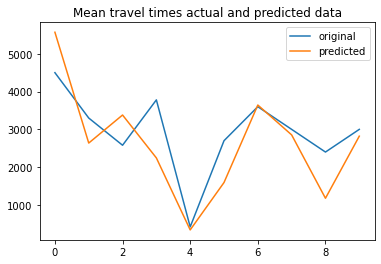

In [39]:
x_ax = range(len(travel_times_model))
plot.plot(x_ax, travel_times_gmaps, label="original")
plot.plot(x_ax, travel_times_model, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

# Live testing

In [40]:
lat1 = 13.002385
long1 = 77.568491
lat2 = 13.061071
long2 = 77.597371
hod = 10

df = prepare_df(lat1, long1, lat2, long2, hod)
predict(df)

array([1395.1552], dtype=float32)